### Make required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from interpret import show
from interpret import data
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

warnings.filterwarnings("ignore")
cos_target = 'COS_cgo'

### Load dataframe and separate feature and target sets

In [2]:
df = pd.read_pickle('COS_Seesaw_dataframe.pkl')
print(df)
columns = list(df.columns)
if cos_target in columns:
    columns.remove(cos_target)
else:
    print('Error, target column not in dataframe')
    quit()
    
x = df[columns]
y = df[cos_target]

          time  COS_cgo     NH_sst     SH_sst  NH_sst-3m  NH_sst-2m  \
4   2000-04-06    495.8  12.102266  14.708376  12.321572  11.899088   
5   2000-04-14    489.4  12.238936  14.623315  12.188755  11.856175   
6   2000-06-07    492.1  13.691157  13.149577  11.858768  12.117429   
7   2000-06-13    473.4  13.930488  13.006068  11.884789  12.236921   
8   2000-06-22    473.5  14.322808  12.789742  12.001824  12.380201   
..         ...      ...        ...        ...        ...        ...   
642 2018-11-14    485.1  14.226390  13.193588  16.219467  16.147058   
643 2018-11-23    486.2  13.903728  13.444789  16.310354  15.985275   
644 2018-12-10    499.9  13.393921  13.930911  16.193851  15.437435   
645 2018-12-10    503.3  13.393921  13.930911  16.193851  15.437435   
646 2018-12-17    507.2  13.160060  14.112185  16.106665  15.210451   

     NH_sst-1m  SH_sst-3m  SH_sst-2m  SH_sst-1m  
4    11.855376  14.329835  15.088497  15.101149  
5    11.894365  14.549086  15.152887  15.040163

### Make test train split, random seed is to ensure consistent results on multiple runs
### change  seed value to get different split

In [3]:
seed = 2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

# set up for predicted vs actual plot
# sorting the test set should not matter since we are not using it to train
X_test = X_test.sort_index()
y_test = y_test.sort_index()

test_time = X_test['time']
X_test.drop(axis=1, labels='time', inplace=True)

#drop time in X_train
X_train.drop(axis=1, labels='time', inplace=True)

### Show Marginal

In [4]:
marginal = data.Marginal()
marginal_explanation = marginal.explain_data(X_train, y_train)
show(marginal_explanation)

<!-- http://127.0.0.1:7001/140159146183168/ -->

### Train Models

In [5]:
ebm = ExplainableBoostingRegressor(random_state=seed, interactions=3)
ebm.fit(X_train, y_train)

lr = LinearRegression(random_state=seed)
lr.fit(X_train, y_train)

rt = RegressionTree(random_state=seed)
rt.fit(X_train, y_train)

### What model learned

In [6]:
ebm_global = ebm.explain_global(name='EBM')
lr_global = lr.explain_global(name='Linear Regression')
rt_global = rt.explain_global(name='Regression Tree')

### Explanation of individul prediction

In [7]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')
lr_local = lr.explain_local(X_test, y_test, name='Linear Regression')
rt_local = rt.explain_local(X_test, y_test, name='Regression Tree')

### Evaluate performance

In [8]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')
lr_perf = RegressionPerf(lr.predict).explain_perf(X_test, y_test, name='Linear Regression')
rt_perf = RegressionPerf(rt.predict).explain_perf(X_test, y_test, name='Regression Tree')

### Everything at once

In [9]:
show([marginal_explanation, lr_global, lr_perf, lr_local, rt_global, rt_perf, rt_local, ebm_global, ebm_perf, ebm_local])

<!-- http://127.0.0.1:7001/140158306236736/ -->
 Open in new window

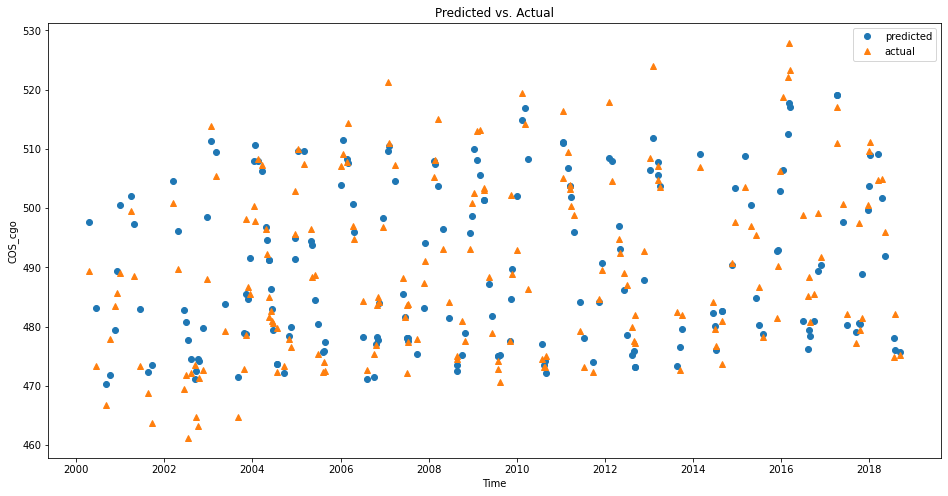

In [10]:
predicted = ebm.predict(X_test)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test_time, predicted, 'o',  label='predicted')
ax.plot(test_time, y_test, '^', label='actual')
ax.set_title("Predicted vs. Actual")
ax.set_xlabel('Time')
ax.set_ylabel('COS_cgo')
plt.legend()
plt.show()
fig.savefig('predictedVsActualOverTime.png')